In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 2.18 s


In [3]:
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'

time: 944 µs


In [4]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 128 FITS files
time: 6.63 ms


In [5]:
import pyjs9

ModuleNotFoundError: No module named 'pyjs9'

time: 28.4 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

In [5]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    force_new=True,
    cursor=tess_cursor,
)

# Display example
display(point_sources.head())
print(f'Sources extracted: {len(point_sources)}')

,ra,dec,x,y,xpeak_image,ypeak_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
10777186,297.767960,27.716880,448,2142,447.7061,2142.1719,3231.971,30788.46,2257.431,13.7790,...,22732.92,1577.937,14.1084,0.0754,3076.094,6.95,0,7.628,7.58872,5.655294
10883789,297.755282,26.813254,766,2149,766.2598,2148.8264,3299.973,13486.62,1649.770,14.6752,...,13376.79,1575.959,14.6841,0.1279,2455.175,4.56,0,7.077,8.14900,7.799772
11027938,297.727150,24.627367,1533,2164,1533.3717,2164.3020,3357.790,57670.23,2569.349,13.0976,...,42759.13,1582.162,13.4224,0.0402,6737.298,3.76,0,7.442,7.43070,5.443080
11036706,297.869000,24.322085,1640,2120,1640.6381,2120.0442,3208.968,23133.84,2236.825,14.0894,...,15624.50,1577.544,14.5155,0.1096,2586.156,2.02,0,7.629,8.67000,5.190274
11133818,297.903248,26.226025,973,2104,973.2496,2104.0847,3332.072,52708.25,3299.416,13.1953,...,36888.30,1583.137,13.5828,0.0466,4101.782,5.93,0,7.542,7.48000,5.941396


Sources extracted: 1034
time: 7.63 s


#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [6]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=False
)

time: 1.06 s


In [7]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 128 Sources: 1765
time: 15.9 ms


## Filter detected sources

The above sequence does basic source filtering via `sextractor` along with what can be matched in the TESS catalog. Below are a number of different ways to filter the frames and/or sources based on image quality, number of detections, etc.

The filtering for the `PAN012` HD189733 data set involves the steps below. At the bottom of the notebook are optional filter methods.

#### Image filtering

We can do some quick checks on the overall image sequence. here we look at the mean background as detected by `sextractor`. It's a rough metric but we can clearly see some frames where the background levels spike, indicating clouds in the region.

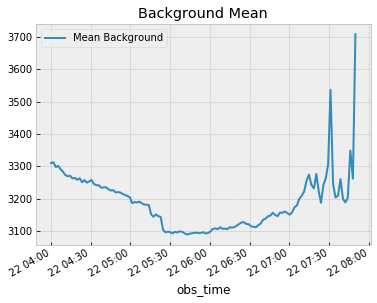

time: 316 ms


In [8]:
plt.figure(figsize=(6, 4.5))
observation_sources.groupby('obs_time').background.mean().plot(label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Filter frames by number of detected sources

Here we remove frames where the total number of detected frames is outside of one standard deviation of the mean number of detected sources.

In [10]:
num_sources = observation_sources.groupby('obs_time').count().file
min_sources = num_sources.mean() - num_sources.std()

time: 31.4 ms


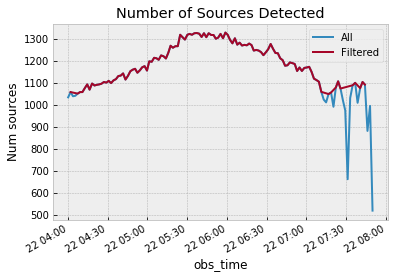

time: 610 ms


In [11]:
observation_sources.groupby('obs_time').count().file.plot(label='All')
observation_sources.groupby('obs_time').filter(lambda grp: grp.count()['file'] >= min_sources).groupby('obs_time').count().file.plot(label='Filtered')
plt.ylabel('Num sources')
plt.title('Number of Sources Detected')
plt.legend()

In [12]:
# Filter out the frames where the number of source detections is outside the std
observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: grp.count()['file'] >= min_sources)

time: 235 ms


In [13]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 114 Sources: 1747
time: 17 ms


#### Filter sources by number of frames

Now that we have removed frames where there were a low number of detections (presumably from clouds) we now want to remove sources that don't appear in most of the frames.

In [14]:
frame_count = observation_sources.groupby('picid').count().file
min_frame_count = int(frame_count.max() * .9)

print(f'Total frames: {frame_count.max()} Min cutout: {min_frame_count}')

Total frames: 114 Min cutout: 102
time: 34 ms


Text(0.5, 1.0, 'Total number of frames')

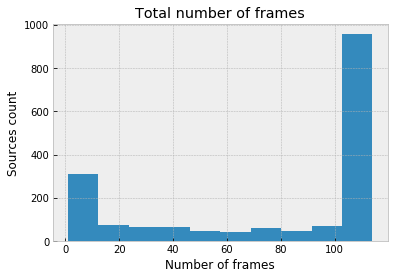

time: 261 ms


In [29]:
# Show a sample of the source count
frame_count.hist()
plt.xlabel('Number of frames')
plt.ylabel('Sources count')
plt.title('Total number of frames')

In [16]:
# Filter out the sources where the number of frames is less than min_frame_count
observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp.count()['file'] >= min_frame_count)

time: 2.03 s


In [17]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 114 Sources: 961
time: 11.5 ms


#### Filter frames by manual time-clipping

For now we are going to simply manually remove the frames after a certain time that was visually identified with cloud cover.

In [ ]:
observation_sources = observation_sources.loc[observation_sources.index.levels[1] < '2018-08-22 07:10:00']

#### Filter frames by Sigma-clip

We can sigma clip the frames based on the mean background value, removing any frame that deviate wildly from the rest of the sequence.

In [ ]:
back_mean, back_median, back_std = sigma_clipped_stats(image_group.background.mean())

observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: np.abs(grp['background'].mean() - back_mean) <= 3 * back_std )

num_frames = len(observation_sources.index.unique())

In [ ]:
num_frames = len(observation_sources.index.levels[1].unique())
num_sources = len(observation_sources.index.levels[0].unique())
print(f"Frames: {num_frames} Sources: {num_sources}")

In [ ]:
plt.figure(figsize=(6, 4.5))
plt.plot(observation_sources.groupby('obs_time').background.mean().values, label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [18]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 114 Sources: 961
time: 11.9 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [19]:
observation_sources = observation_sources.groupby('picid').filter(lambda grp: all(grp['flags'] < 4))

time: 475 ms


In [20]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 114 Sources: 847
time: 11.9 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [28]:
snr_limit = 10

observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp['snr'].mean() > snr_limit)

time: 362 ms


In [29]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 114 Sources: 344
time: 5.94 ms


#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [21]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

time: 791 µs


In [22]:
observation_sources.to_csv(filtered_filename)

time: 2.9 s
